In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path="../code/data/"

In [3]:
import docker
from io import StringIO

client = docker.from_env()
client.containers.list()
container=client.containers.get("datalab_s22")
container.attach()

b''

In [4]:
def getFileName(N,sigma,amplitude,freq=0,deltaT=1,phase=0):
    return "N=%s-s=%s-d=%s-f=%s-a=%s-p=%s" % (N ,sigma, deltaT, freq, amplitude, phase)

In [5]:
def generate_source(N,sigma,amplitude,freq=0,deltaT=1,phase=0):
    filename = "N=%s-s=%s-d=%s-f=%s-a=%s-p=%s" % (N ,sigma, deltaT, freq, amplitude, phase)
    container.exec_run("/home/generate_source -N %s -s %s -d %s -f %s -a %s -p %s -o %s" % (N ,sigma, deltaT, freq, amplitude, phase, "/home/data/out_"+filename))
    return pd.read_csv(path+"out_"+filename,delimiter=' ',header=None)

In [6]:
def prober(filename,method,freq_prober=0,phi=0):
    if method==3:
        return container.exec_run("/home/prober -i %s -o %s -m %s" % ("home/data/out_"+filename ,"home/data/prober_"+filename, method))
    else:
        return container.exec_run("/home/prober -i %s -f %s -p %s -m %s" % ("home/data/out_"+filename, freq_prober, phi, method))

In [7]:
def method_one(filename,freq,phi):
    prober_return = str(prober(filename,1,freq,phi).output,'utf-8').split()
    return prober_return

In [8]:
def method_two(filename,freq):
    prober_return = [str(prober(filename,2,freq,i/250*2*np.pi).output,'utf-8').split() for i in range(0,250)]
    return pd.DataFrame(prober_return,dtype=float)

In [9]:
def method_three(filename):
    prober(filename,method=3)
    result=pd.read_csv(path+"prober_"+filename,delimiter=' ',header=None)
    plt.plot(result[0],result[2])
    plt.show()
    return result

In [10]:
def findSignal(filename):
    #generate_source()
    df = method_three(filename)
    freq  = df[0][df[2].idxmax(0)]
    df = method_two(filename,freq)    
    phi  = df[1][df[2].idxmin(0)]
    df = method_one(filename,freq,phi)  
    ampl = float(df[2])*2
    return freq,phi,ampl

In [11]:
getFileName(10000,16,1,100,0.001)

'N=10000-s=16-d=0.001-f=100-a=1-p=0'

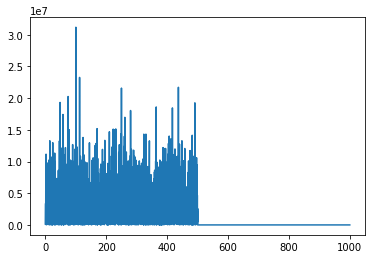

(100.0, 0.100531, 1.116804)

In [12]:
findSignal('N=10000-s=16-d=0.001-f=100-a=1-p=0')

*  Wie ist das mit der Amplitude aus der FFT zu berechnen. Dazu braucht man ja die Phase. Aber wie geht das?

In [13]:
def signalToDf(filename):
    return pd.read_csv(path+"out_"+filename,delimiter=' ',header=None)

In [14]:
signalToDf('N=10000-s=16-d=0.001-f=100-a=1-p=0')

,0,1
0,0.000,4.930285
1,0.001,3.440588
2,0.002,15.401697
3,0.003,-6.635899
4,0.004,2.930019
...,...,...
9995,9.995,2.637122
9996,9.996,-24.293419
9997,9.997,11.900341
9998,9.998,-3.043582


In [17]:
generate_source(N=10000,sigma=16,amplitude=1.44,freq=106.3,deltaT=0.0004,phase=0.3)

,0,1
0,0.0000,10.347052
1,0.0004,14.344256
2,0.0008,-31.541992
3,0.0012,-1.245603
4,0.0016,12.287149
...,...,...
9995,3.9980,-4.279735
9996,3.9984,-31.226187
9997,3.9988,-12.716520
9998,3.9992,-12.249658


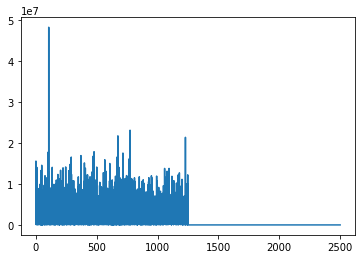

(106.25, 0.703717, 1.389202)

In [18]:
findSignal(getFileName(N=10000,sigma=16,amplitude=1.44,freq=106.3,deltaT=0.0004,phase=0.3))

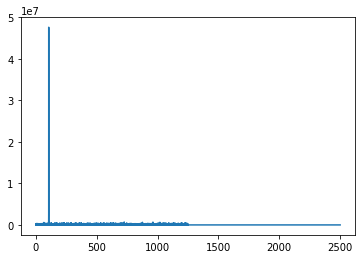

(106.25, 0.854513, 1.380528)

In [20]:
generate_source(N=10000,sigma=3,amplitude=1.44,freq=106.3,deltaT=0.0004,phase=0.3)
findSignal(getFileName(N=10000,sigma=3,amplitude=1.44,freq=106.3,deltaT=0.0004,phase=0.3))

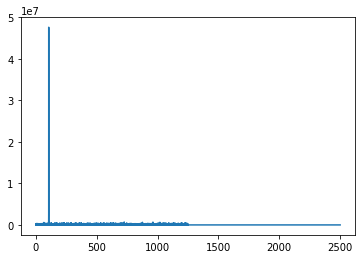

(106.25, 0.854513, 1.380528)

In [21]:
generate_source(N=50000,sigma=3,amplitude=1.44,freq=106.3,deltaT=0.0004,phase=0.3)
findSignal(getFileName(N=10000,sigma=3,amplitude=1.44,freq=106.3,deltaT=0.0004,phase=0.3))